A Random Forest model to predict weather a ship was fishing or not. The training data for the model was generated by Kristina Boerder at Dalhousie University. The data has AIS messages and labels for weather the ship was fishing or not and the type of fishing gear used.

### Generating the training dataset.
This repository by [https://github.com/GlobalFishingWatch/training-data](GFW) contains the dataset required to run the model. To generate the dataset:
1. Clone the repository.
2. Run `git lfs pull`. The dataset converted to numpy arrarys and pickled.
3. Run `./prepare.sh`.

In [15]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [16]:
df_purse_seiners = np.load("../stomar/training-data/data/merged/kristina_ps.npz")
data = df_purse_seiners['x']

data = pd.DataFrame(data, columns=data.dtype.names)
data.dropna(how='any', inplace=True)

data.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
0,1.088051e+13,1.325378e+09,0.0,27585.552734,0.0,246.300003,34.871735,138.330841,-1.0
1,1.088051e+13,1.325401e+09,0.0,27585.552734,0.0,98.400002,34.871742,138.330811,-1.0
2,1.088051e+13,1.325401e+09,0.0,27585.552734,0.0,123.599998,34.871754,138.330826,-1.0
3,1.088051e+13,1.325408e+09,0.0,27585.552734,0.0,136.199997,34.871735,138.330856,-1.0
4,1.088051e+13,1.325414e+09,0.0,27585.552734,0.0,168.100006,34.871746,138.330841,-1.0


In [17]:
### Feature engineering
### Convert timestamps to Eastern Australian time-zone.

from datetime import datetime, timedelta
import pytz

def convert_epoch_to_datetime(timestamp):
    utc_dt = datetime.utcfromtimestamp(timestamp).replace(tzinfo=pytz.utc)
    au_tz = pytz.timezone('Australia/Sydney')
    au_dt = au_tz.normalize(utc_dt.astimezone(au_tz))
    return au_dt


data['timestamp'] = data['timestamp'].apply(lambda x: convert_epoch_to_datetime(x))
data['day'] = data['timestamp'].apply(lambda x: x.hour > 12)
data.head()

features = data[['distance_from_shore', 'speed', 'course', 'day']]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, data['is_fishing'], test_size=0.20)
print "Training and testing split was successful."
print X_train.head(), y_train.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,day
0,1.088051e+13,2012-01-01 11:39:44+11:00,0.0,27585.552734,0.0,246.300003,34.871735,138.330841,-1.0,False
1,1.088051e+13,2012-01-01 18:01:43+11:00,0.0,27585.552734,0.0,98.400002,34.871742,138.330811,-1.0,True
2,1.088051e+13,2012-01-01 18:01:53+11:00,0.0,27585.552734,0.0,123.599998,34.871754,138.330826,-1.0,True
3,1.088051e+13,2012-01-01 19:51:42+11:00,0.0,27585.552734,0.0,136.199997,34.871735,138.330856,-1.0,True
4,1.088051e+13,2012-01-01 21:39:23+11:00,0.0,27585.552734,0.0,168.100006,34.871746,138.330841,-1.0,True


In [9]:
features = data[['distance_from_shore', 'speed', 'course', 'day']]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, data['is_fishing'], test_size=0.20)
print "Training and testing split was successful."
print X_train.head(), y_train.head()

Training and testing split was successful.
         distance_from_shore  speed    course
336619           2236.013184    0.1  0.354167
1071540        706139.875000    0.6  0.837778
288462         170788.078125    1.8  0.369167
1601385             0.000000    0.0  0.830556
1489208             0.000000    0.0  0.454167 336619    -1.0
1071540   -1.0
288462     0.0
1601385   -1.0
1489208   -1.0
Name: is_fishing, dtype: float32


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


regressor = RandomForestClassifier(n_estimators=500)
regressor.fit(X_train, y_train)

regressor.predict(X_test)

print regressor.feature_importances_

In [11]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "Number of predictions does not match number of outcomes!"


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

regressor = RandomForestClassifier(n_estimators=500)
regressor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [13]:
regressor.predict(X_test)

array([-1.,  0., -1., ..., -1., -1., -1.], dtype=float32)

In [14]:
print regressor.feature_importances_

importances = pd.DataFrame({'feature':X_train.columns,'feature importance':np.round(regressor.feature_importances_,3)})
importances = importances.sort_values('feature importance',ascending=False).set_index('feature')
print importances
importances.plot.bar()
plot.show()

[ 0.49426045  0.14989341  0.35584614]


In [15]:
print accuracy_score(y_test, regressor.predict(X_test))

Predictions have an accuracy of 98.31%.


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    from itertools import izip
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():

    plot_classification_report(classification_report(y_test, regressor.predict(X_test)))
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

'             precision    recall  f1-score   support\n\n       -1.0       0.98      1.00      0.99    298923\n        0.0       0.98      0.84      0.91     32164\n        1.0       0.99      0.98      0.98      1245\n\navg / total       0.98      0.98      0.98    332332\n'

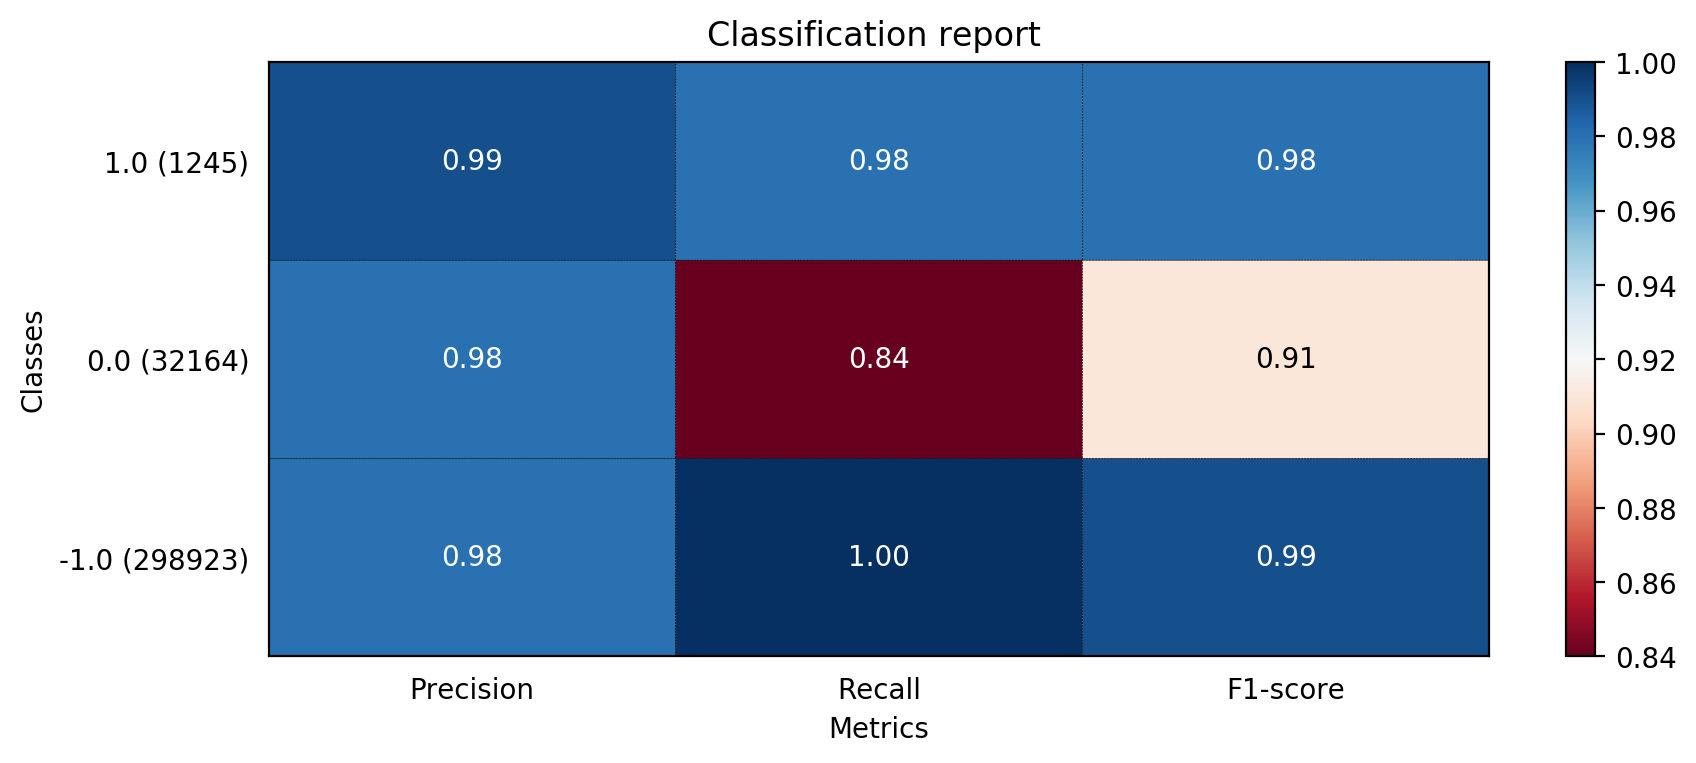

In [18]:
from IPython.display import Image
Image(filename='test_plot_classif_report.png')